## Question 3

<p><b> Question 3: Random Forest</b></p>
Classifying benign vs malignant tumors: We would like to classify if a tumor is benign
or malign based on its attributes. We use data from the Breast Cancer Wisconsin Data Set of
the UCI Machine Learning Repository:
https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original).
The input file is named “hw2 question3.csv” for our experiments. The rows of these files refer
to the data samples, while the columns denote the features (columns 1-9) and the outcome
variable (column 10), as described bellow:
<p>
1. Clump Thickness: discrete values {1, 10}
2. Uniformity of Cell Size: discrete values {1, 10}
3. Uniformity of Cell Shape: discrete values {1, 10}
4. Marginal Adhesion: discrete values {1, 10}
5. Single Epithelial Cell Size: discrete values {1, 10}
6. Bare Nuclei: discrete values {1, 10}
7. Bland Chromatin: discrete values {1, 10}
8. Normal Nucleoli: discrete values {1, 10}
9. Mitoses: discrete values {1, 10}
10. Class: 2 for benign, 4 for malignant (this is the outcome variable)
</p>

In [2]:
#Importing all our dependencies  

#dependencies for data manipulation
import numpy as np
import pandas as pd

# dependencies for plotting
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib as mpl
import seaborn as sns

# dependencies for statistic analysis
import statsmodels.api as sm
from scipy import stats

#importing our parameter tuning dependencies
from sklearn.model_selection import (cross_val_score, GridSearchCV,StratifiedKFold, ShuffleSplit )
#importing our dependencies for Feature Selection
from sklearn.feature_selection import (SelectKBest, chi2, RFE, RFECV)
#from sklearn.cross_validation import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from collections import defaultdict
from sklearn.metrics import roc_auc_score

# Importing our sklearn dependencies for the modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
#from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)
from itertools import cycle
from scipy import interp
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [23]:

# Plot formatting

def plt_format():
    %matplotlib inline
    plt.rc('font', family='DejaVu Sans')
    plt.figure(figsize=(16,14))
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams['font.size'] = 16
    sns.set(style="ticks", color_codes=True)
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 32
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['axes.linewidth'] = 1
    
plt_format()

<Figure size 1152x1008 with 0 Axes>

In [24]:
# opening the dataset

pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 33)
data = pd.read_csv('hw2_question3.csv')

In [25]:
data.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [26]:
# inspecting the first five rows 
print("Dataset total observations: ", len(data))
print("Dataset shape: Columns, rows", data.shape)
data.head(5)

Dataset total observations:  683
Dataset shape: Columns, rows (683, 10)


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [27]:
data.isnull().sum()

Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [28]:
data['Class'].replace(2, 0,inplace=True)
data['Class'].replace(4, 1,inplace=True)
#data.head(50)

<Figure size 1152x1008 with 0 Axes>

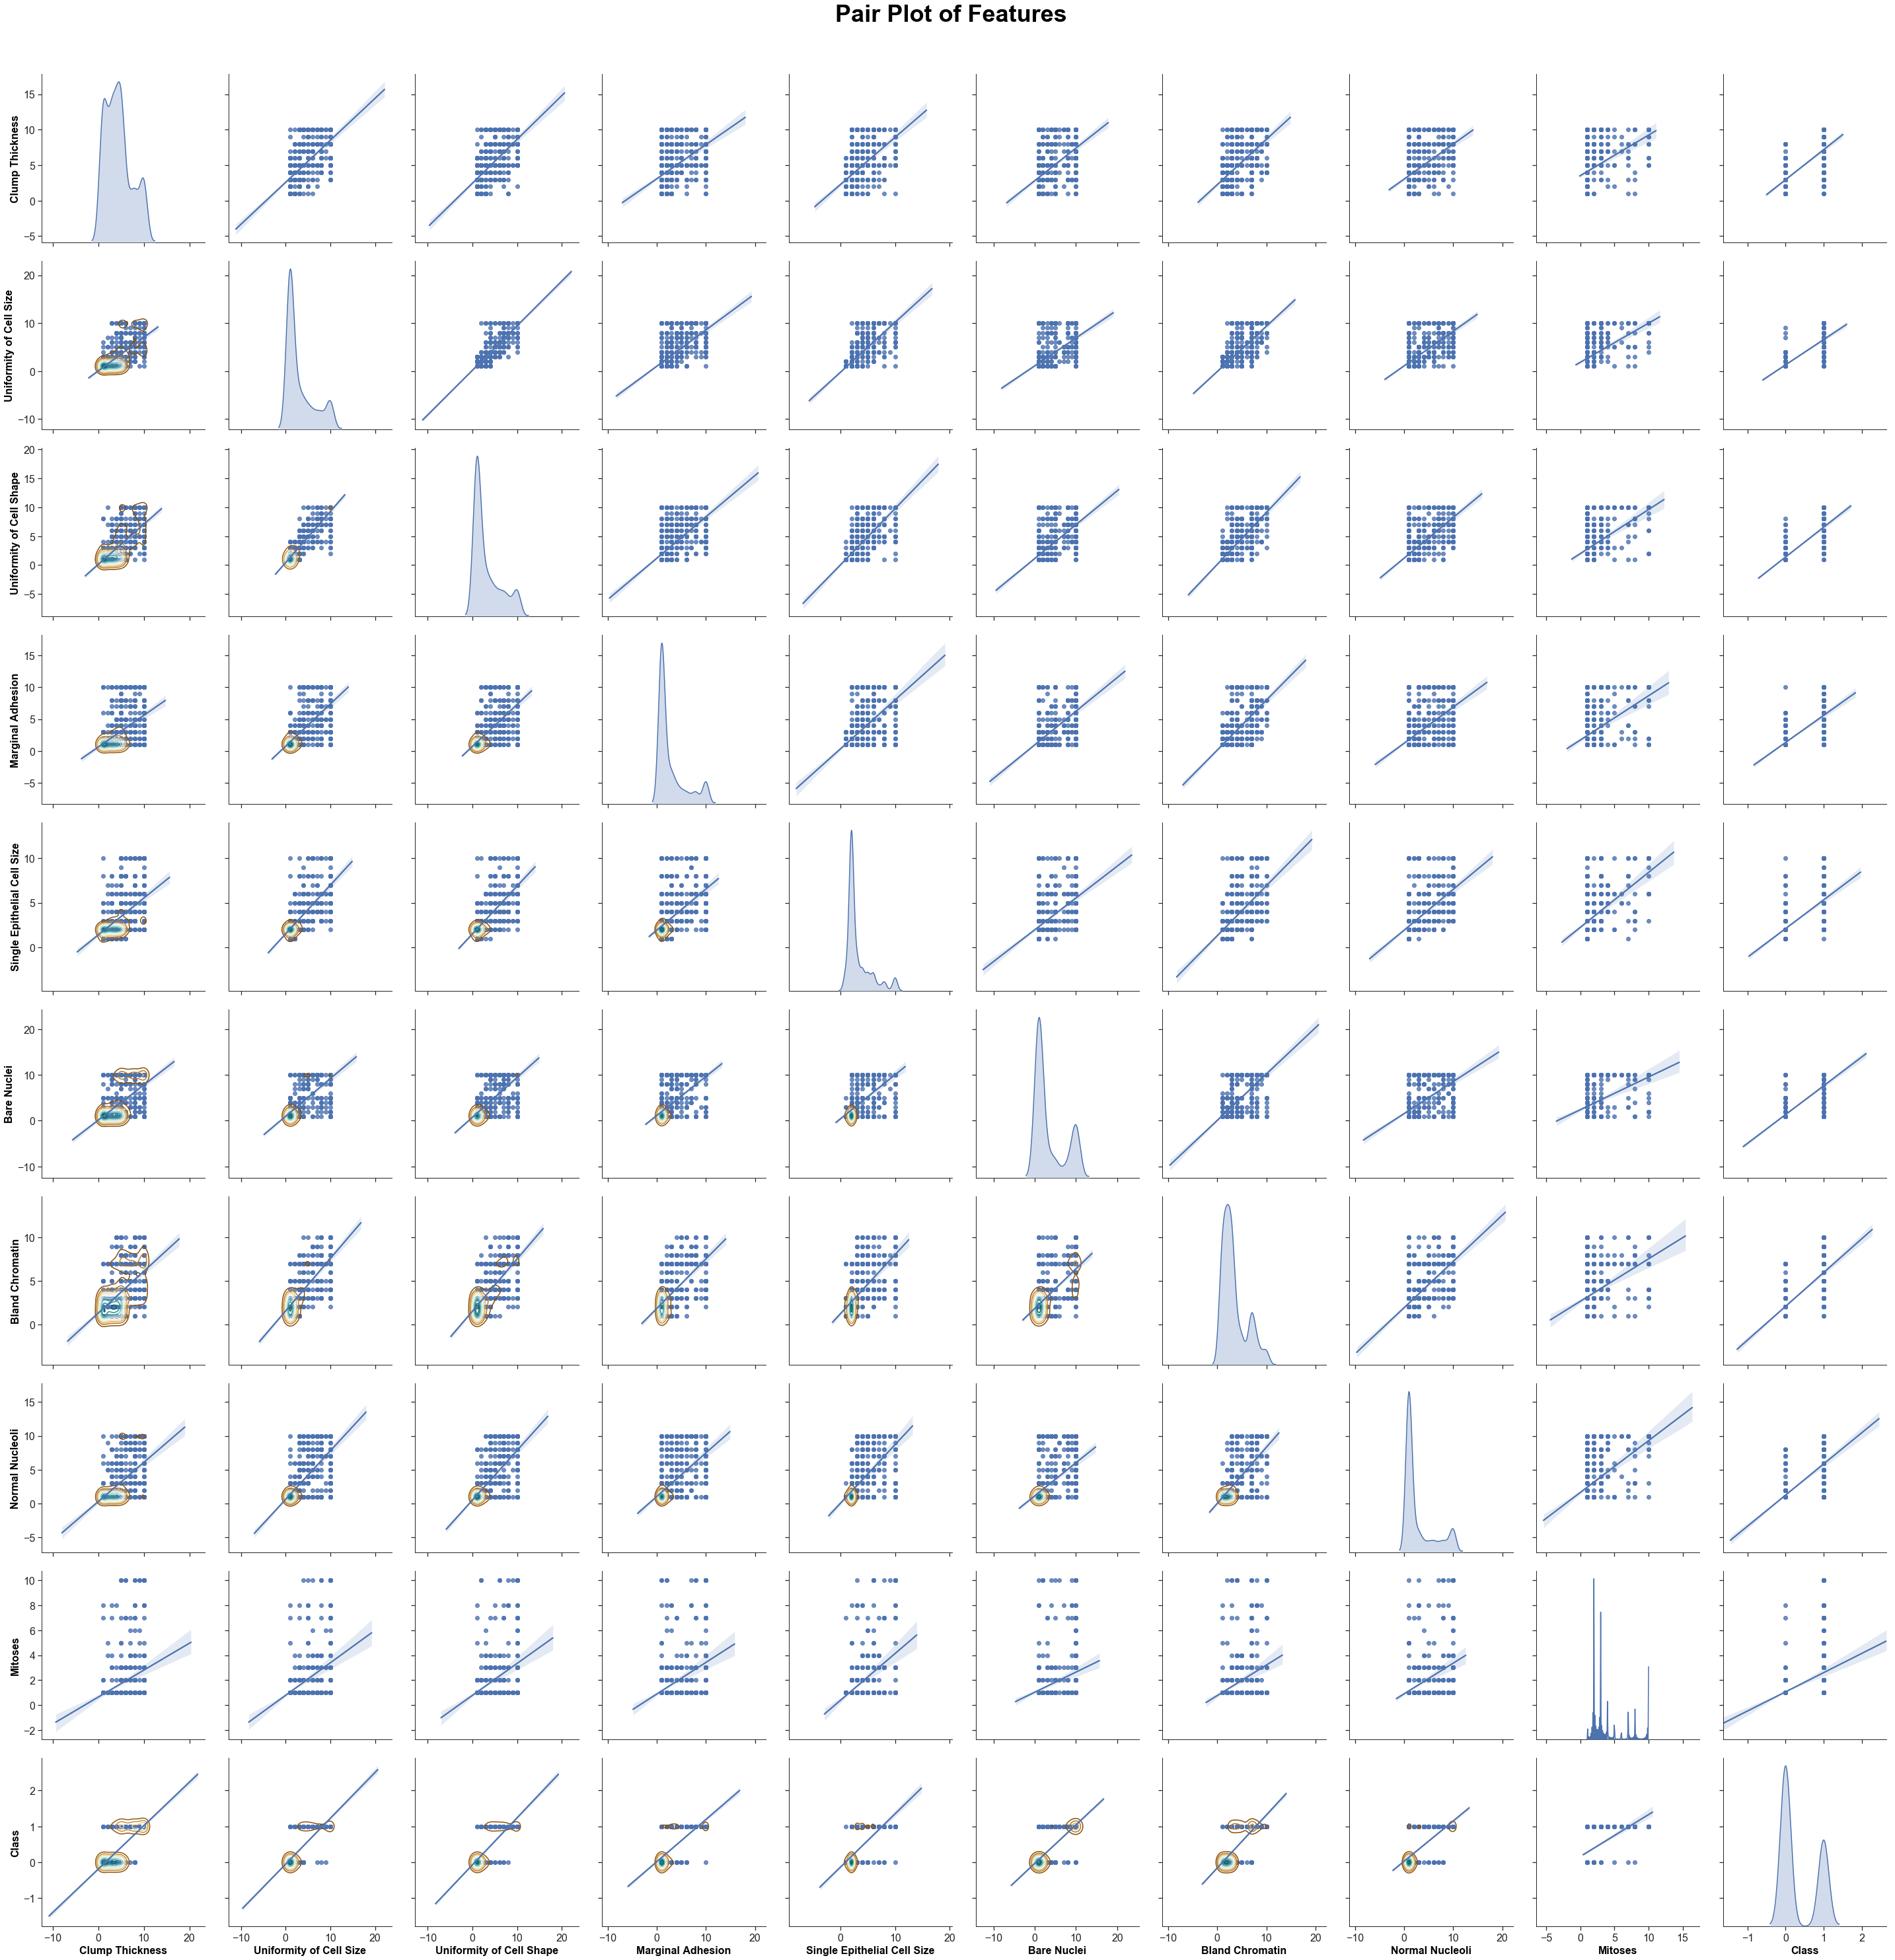

In [29]:
# Pairplot
plt_format()
g = sns.pairplot(data, kind='reg', size=4,diag_kind= "kde", diag_kws=dict(shade=True))
g.map_lower(sns.kdeplot, cmap='BrBG')
plt.suptitle('Pair Plot of Features', y=1.03, weight='heavy', fontsize=36);

## Part a

<p>Compute the number of samples belonging to the benign and the number of samples
belonging to the malignant case. What do you observe? Are the two classes equally
represented in the data? Separate the data into a train (2/3 of the data) and a test (1/3 of the
data) set. Make sure that both classes are represented with the same proportion in both sets.</p>

Number of samples belonging to benign is  444
Number of samples belonging to malignant is  239


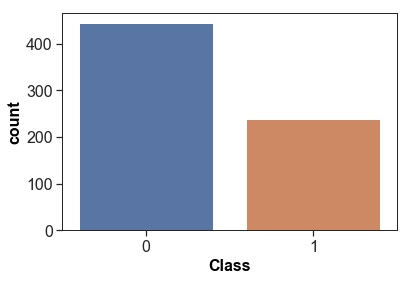

In [30]:
print ('Number of samples belonging to benign is ',len(data[data.Class==0]))
print ('Number of samples belonging to malignant is ',len(data[data.Class==1]))
sns.countplot(x='Class',data=data)
plt.show()

<p> Looking at the above data, we infer that the two classes are not represented equally in the dataset. We need to make sure that the train test split have data represented in the same proportion as the dataset</p>

In [31]:
#input features (independent variables)
X = data.iloc[:,0:9]

#predictor (dependent variable)
y = data.iloc[:,9] 

#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [32]:
#Split the data into training and test set keeping the proportion of response same
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.33)

## Part b

<p>Implement two decision trees using the training samples. The splitting criterion for the
first one should be the entropy, while for the second one should be the gini index. Plot the
2
10-fold stratified cross validated accuracy on the train and test data while the maximum depth
in the tree increases for both splitting criteria. Do you observe any differences in practice?
</p>

In [33]:
scaler = StandardScaler().fit(X_train)
Xt = pd.DataFrame(scaler.transform(X), columns = X.columns)
train_X = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
test_X = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

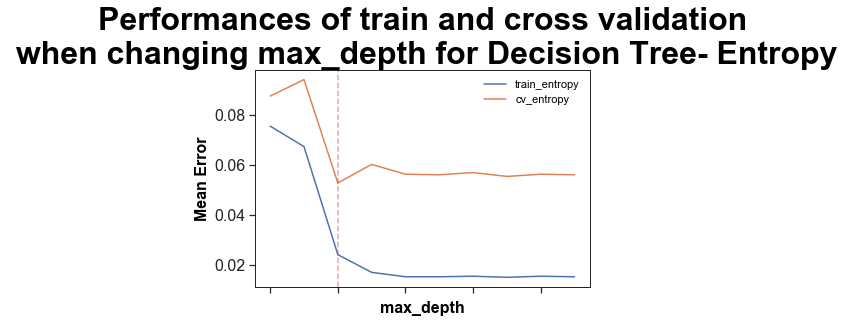

In [34]:
# Calculating and plotting 10 fold cross validation for both splitting criterion
dtc_paras={"max_depth":[1,2,4,6,9,12,15,20,25,30]}  # Increaseing Depths
resTreepd = pd.DataFrame(dtc_paras)
resTreepd["train_entropy"] = resTreepd["cv_entropy"] = np.zeros(len(dtc_paras["max_depth"]))
repeat = 10

#Cross Validation with Entropy as the splitting criteria
for _ in range(repeat):
    dtc1=DecisionTreeClassifier(criterion = "entropy",min_samples_split = 10)
    gscvTree1=GridSearchCV(dtc1, dtc_paras,cv=5,n_jobs=2)
    gscvTree1.fit(train_X, y_train)
    resTree1 = gscvTree1.cv_results_
    resTreepd["train_entropy"] += 1-np.array(resTree1['mean_train_score'])
    resTreepd["cv_entropy"] += 1-np.array(resTree1['mean_test_score'])
resTreepd["train_entropy"] /= repeat
resTreepd["cv_entropy"] /= repeat
resTreepd.max_depth = resTreepd.max_depth.astype(str)
resTreepd=resTreepd.set_index(["max_depth"])
ax1=resTreepd.plot(title="Performances of train and cross validation\n when changing max_depth for Decision Tree- Entropy")
ax1.set_ylabel("Mean Error")
idxmin1 = [i for i in range(resTreepd.shape[0]) if resTreepd.index[i] == resTreepd.idxmin()['cv_entropy']]
ax1.axvline(x=idxmin1[0],color='r',ls='--',alpha=0.5)
plt.show()

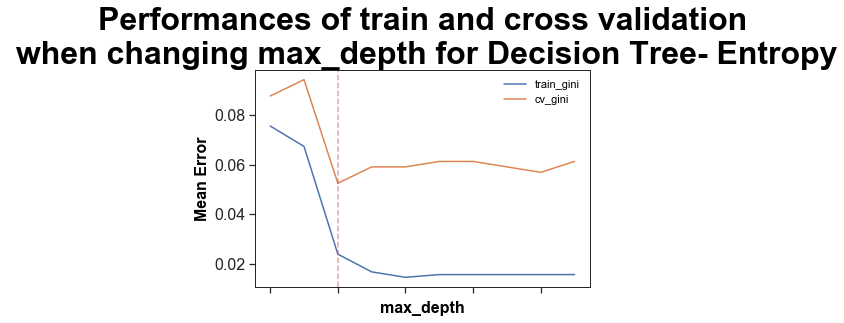

In [35]:
#Cross Validation with Gini as the splitting criteria
dtc_paras={"max_depth":[1,2,4,6,9,12,15,20,25,30]}  # Increaseing Depths
resTreepd = pd.DataFrame(dtc_paras)
resTreepd["train_gini"] = resTreepd["cv_gini"] = np.zeros(len(dtc_paras["max_depth"]))
repeat = 10
for _ in range(repeat):
    dtc2=DecisionTreeClassifier(criterion = "gini",min_samples_split = 10)
    gscvTree2=GridSearchCV(dtc2, dtc_paras,cv=5,n_jobs=2)
    gscvTree2.fit(train_X, y_train)
    resTree2 = gscvTree2.cv_results_
    resTreepd["train_gini"] += 1-np.array(resTree1['mean_train_score'])
    resTreepd["cv_gini"] += 1-np.array(resTree1['mean_test_score'])
resTreepd["train_gini"] /= repeat
resTreepd["cv_gini"] /= repeat
resTreepd.max_depth = resTreepd.max_depth.astype(str)
resTreepd=resTreepd.set_index(["max_depth"])
ax2=resTreepd.plot(title="Performances of train and cross validation\n when changing max_depth for Decision Tree- Entropy")
ax2.set_ylabel("Mean Error")
idxmin2 = [i for i in range(resTreepd.shape[0]) if resTreepd.index[i] == resTreepd.idxmin()['cv_gini']]
ax2.axvline(x=idxmin2[0],color='r',ls='--',alpha=0.5)
plt.show()

<p> From the above two splitting criteria, we notice that entropy achieves minimum error faster earlier than gini. However if we change the minimum sample split criteria, probably we will better able to decide on the better splitting criteria between gini and entropy.
<br> Let us now try a parametric grid search to find the best parameters</b></p>

In [36]:
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2,3,4, 5,6, 10, 20],
              "max_depth": [2, 3,4,5,6,7, 10, 15, 20],
              }

tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid=param_grid, cv=10)

tree_gs.fit(train_X, y_train)
tree_gs.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3}

In [37]:
results = []
y_pred = tree_gs.predict(test_X)
results.append(y_pred) 

print ("Decision Tree Accuracy : ",(f1_score(y_test, y_pred, average='weighted') * 100.0))


Decision Tree Accuracy :  95.1397433026153


## Part c

<p>Feature Importance Run a 10-fold stratified cross-validation for modeling this problem with
a random forest model. You can choose to do a secondary 10-fold cross-validation on the
training set in each fold to find the optimal number of trees and depth of each tree if you
choose. Is this model more accurate (averaged over all 10 folds) than the decision trees?. As
ranked by the feature importance, please provide a ranking of the features as their average
position (standard deviation) of the rank order. Is this ranking it by Gini, Mean Decrease in
Accuracy, or something else? What should the final model’s list of features be? Please justify
your answer.

</p>

In [38]:
# Random Forest Classifier 
RF_clf = RandomForestClassifier()
# Parameters to tune
RF_par = {"max_depth": [3, None], 
          #"max_features": [1, 3, 10], 
          "min_samples_split": [2, 3, 10], 
          "min_samples_leaf": [1, 3, 10], "bootstrap": [True, False], "criterion": ["gini", "entropy"], 
         }
RF_gs = GridSearchCV(RF_clf, RF_par).fit(train_X, y_train)
RF_gs.best_params_

#y_pred = clf_tuned.predict(test_X)
#results.append(y_pred) 

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [39]:

def compute_roc_auc(index):
    y_predict = RF_tuned.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score




In [40]:
cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
RF_tuned = RandomForestClassifier(n_estimators=250,bootstrap= True, criterion= 'entropy', 
                                  max_depth= None, min_samples_leaf= 1, min_samples_split= 3, oob_score=True)  
for (train, test), i in zip(cv.split(Xt, y), range(10)):
    RF_tuned.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))


aucScore=pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
print(aucScore)

   AUC Train  AUC Test
0        1.0  0.980556
1        1.0  0.987037
2        1.0  0.999074
3        1.0  0.999074
4        1.0  0.994318
5        1.0  0.997159
6        1.0  0.999053
7        1.0  0.977273
8        1.0  0.998106
9        1.0  1.000000


In [41]:
mean_auc=aucScore.loc[:,'AUC Test'].mean()
print('The mean AUC score across all 10 folds of Random forest is',mean_auc)

The mean AUC score across all 10 folds of Random forest is 0.9931649831649831


Thus on comparing with decision trees, random forest performs extremely well and gives high value of AUC score very close to 1

In [46]:
import pickle
def save_model_result(dictionary):
    path = "C:/Users/joelj/Desktop/Machine Learning/Results"
    f = open(path+"Q3_C_50_10.pkl","wb")
    pickle.dump(dictionary,f)
    f.close()
    
def load_model_result():
    path = "C:/Users/joelj/Desktop/Machine Learning/Homework2/Results"
    with open(path+'Q3_C_50_10.pkl', 'rb') as handle:
        b = pickle.load(handle)
    return b

In [50]:
feats = {}

for i in train_X.columns:
    feats[i]=0

for feature, importance in zip(X_train.columns, RF_tuned.feature_importances_):
    feats[feature] += importance/10
    
print("Feature Importance :")

feature_importances = pd.DataFrame([feats[index] for index in X_train.columns],
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)
save_model_result(feats)

Feature Importance :
                             importance
Uniformity of Cell Size        0.024364
Uniformity of Cell Shape       0.018782
Bare Nuclei                    0.017963
Bland Chromatin                0.012113
Single Epithelial Cell Size    0.009640
Normal Nucleoli                0.006856
Clump Thickness                0.005627
Marginal Adhesion              0.003701
Mitoses                        0.000955


<p>Since the splitting criteria is by Entropy, the feature ranking is based with respect to Entropy</p>

<p> The top features to select for the final model are :
    <br><b>Uniformity of Cell Size</b> </br>
<br><b>Uniformity of Cell Shape </b> </br>
<br><b>Bare Nuclei             </b> </br>     
<br><b>Bland Chromatin         </b> </br> 
<br><b>Single Epithelial Cell Size  </b> </br>